In [3]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [4]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('images') if isfile(join('images', f))])

In [5]:
def bound_box(image_path):
    # load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    """print(image.shape)
    plt.imshow(gray, 'gray')"""

    # Find contours
    kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
    image_horizontal_derivative = cv2.filter2D(gray, -1, kernel_horizontal_derivative)
    image_horizontal_derivative = np.abs(image_horizontal_derivative)
    kernel_vertical_derivative = 1/4 * np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
    image_vertical_derivative = cv2.filter2D(gray, -1, kernel_vertical_derivative)
    image_vertical_derivative = np.abs(image_vertical_derivative)

    image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

    """plt.figure()
    plt.imshow(image_horizontal_derivative, 'gray')"""
    
    ret2,thresh = cv2.threshold(image_derivative,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
    closed0 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
    opened = cv2.morphologyEx(closed0, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    opened1 = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    kernel = np.zeros((11,11),np.uint8)
    kernel[5,:] = 1
    dilated = cv2.dilate(opened1, kernel, iterations = 5)
    
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(cnts)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    #print(rect)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    # draw a bounding box arounded the detected barcode and display the
    # image
    image_bb = image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    
    coordinates_source = box.astype('float32')
    min_width = coordinates_source[:,0].min()
    min_height = coordinates_source[:,1].min()
    max_width = coordinates_source[:,0].max()
    max_height = coordinates_source[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    print(coordinates_source)
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                             dist(coordinates_source[2],coordinates_source[3])]))
    coordinates_destination = np.array([[0, 0],
                                        [destination_width-1, 0],
                                        [0, destination_height-1],
                                        [destination_width-1, destination_height-1]], dtype='float32')
    # Computing the trasformation, i.e. homography. Warping.
    H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)
    # Applying the trasformation
    gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))
    plt.figure()
    plt.imshow(gray1, 'gray')

[[ 404.  262.]
 [1300.  258.]
 [ 408. 1056.]
 [1304. 1051.]]
Wall time: 284 ms


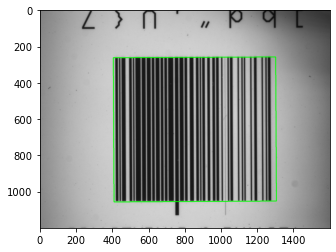

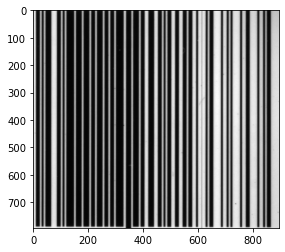

In [60]:
%%time
bound_box(f'images/{images_paths[0]}')

[[ 353.  289.]
 [1253.  289.]
 [ 353. 1086.]
 [1253. 1086.]]
Wall time: 263 ms


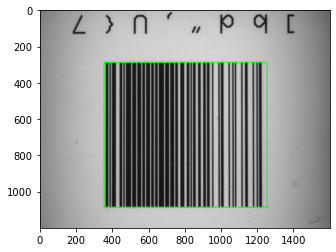

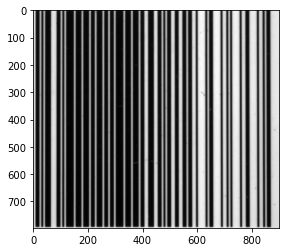

In [61]:
%%time
bound_box(f'images/{images_paths[1]}')

[[ 202.  243.]
 [1048.  238.]
 [ 205.  726.]
 [1051.  721.]]
Wall time: 218 ms


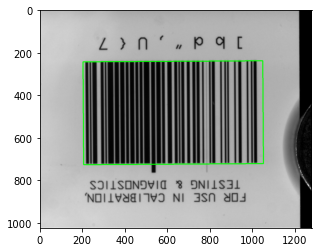

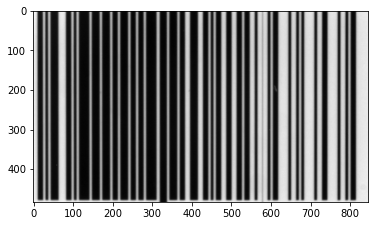

In [62]:
%%time
bound_box(f'images/{images_paths[2]}')

[[132. 259.]
 [978. 259.]
 [132. 742.]
 [978. 742.]]
Wall time: 229 ms


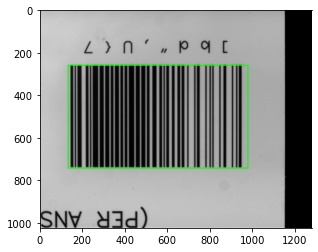

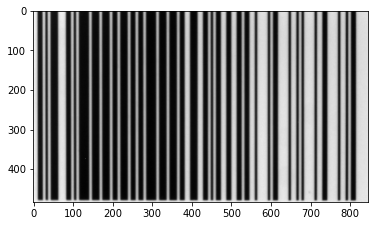

In [63]:
%%time
bound_box(f'images/{images_paths[3]}')

[[330. 173.]
 [910. 173.]
 [330. 696.]
 [910. 696.]]
Wall time: 194 ms


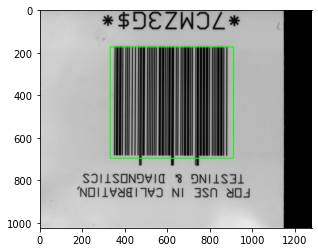

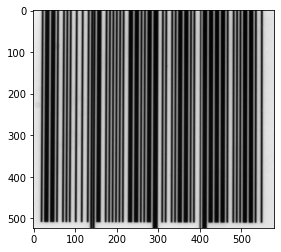

In [64]:
%%time
bound_box(f'images/{images_paths[4]}')

[[335. 252.]
 [918. 252.]
 [335. 765.]
 [918. 765.]]


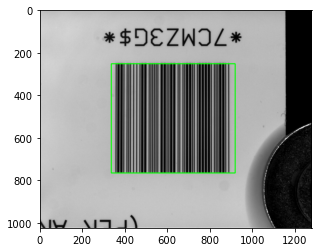

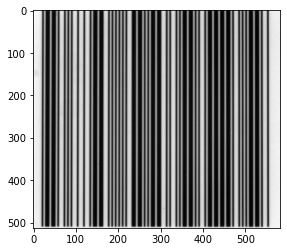

In [11]:
bound_box(f'images/{images_paths[5]}')

[[ 162.  288.]
 [1109.  288.]
 [ 162.  848.]
 [1109.  848.]]


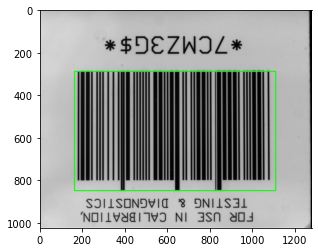

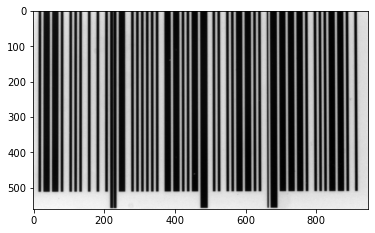

In [12]:
bound_box(f'images/{images_paths[6]}')

[[ 147.  275.]
 [1099.  277.]
 [ 146.  790.]
 [1098.  791.]]


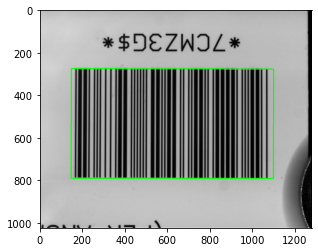

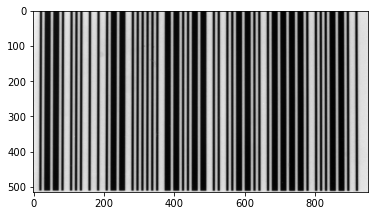

In [13]:
bound_box(f'images/{images_paths[7]}')

[[327. 336.]
 [982. 341.]
 [324. 781.]
 [978. 785.]]


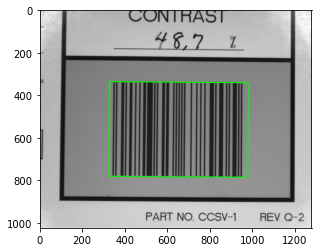

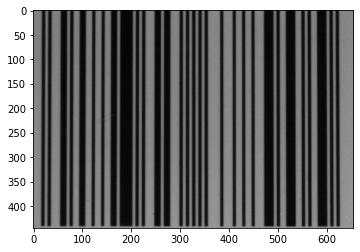

In [14]:
bound_box(f'images/{images_paths[8]}')

[[339. 257.]
 [988. 264.]
 [333. 721.]
 [982. 729.]]


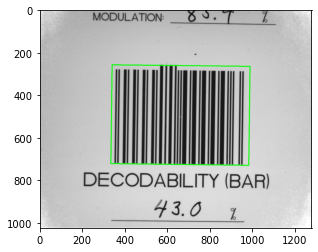

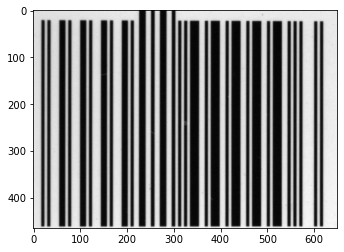

In [15]:
bound_box(f'images/{images_paths[9]}')

In [16]:
print(f'images/{images_paths[10]}')

images/EAN-UPC-DEFECTS IMGB.BMP


In [17]:
#bound_box(f'images/{images_paths[10]}')

[[263. 309.]
 [962. 306.]
 [264. 758.]
 [964. 755.]]


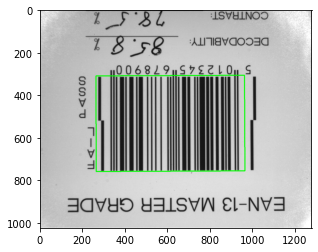

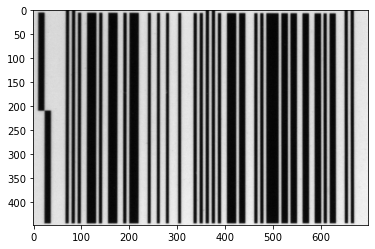

In [18]:
bound_box(f'images/{images_paths[11]}')

In [19]:
bound_box(f'images/{images_paths[12]}')

IndexError: list index out of range

[[ 102.  121.]
 [1302.  121.]
 [ 102.  312.]
 [1302.  312.]]


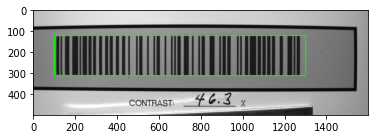

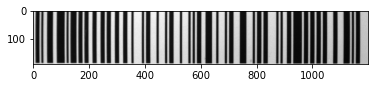

In [20]:
bound_box(f'images/{images_paths[13]}')

[[ 165.  147.]
 [1360.  147.]
 [ 165.  338.]
 [1360.  338.]]


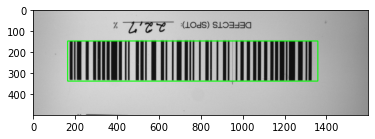

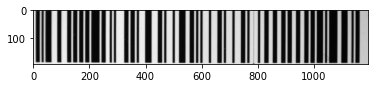

In [21]:
bound_box(f'images/{images_paths[14]}')

[[ 180.  168.]
 [1392.  157.]
 [ 182.  362.]
 [1394.  351.]]


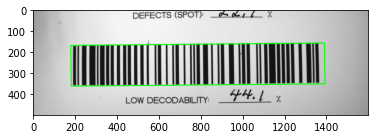

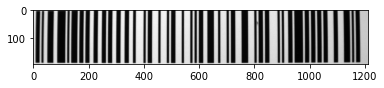

In [22]:
bound_box(f'images/{images_paths[15]}')

[[ 203.  142.]
 [1400.  142.]
 [ 203.  333.]
 [1400.  333.]]


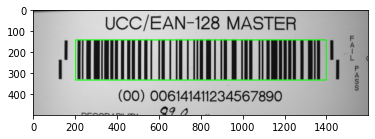

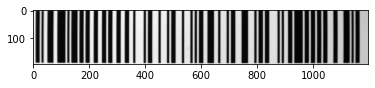

In [23]:
bound_box(f'images/{images_paths[16]}')

[[ 194.  147.]
 [1360.  128.]
 [ 198.  386.]
 [1364.  367.]]


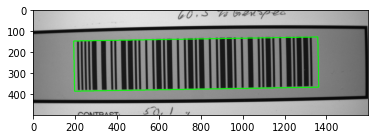

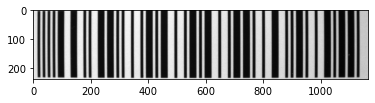

In [24]:
bound_box(f'images/{images_paths[17]}')

[[ 196.  130.]
 [1366.  121.]
 [ 198.  370.]
 [1368.  361.]]


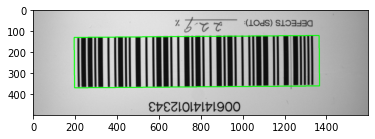

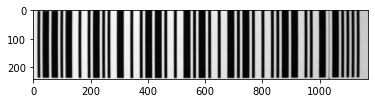

In [25]:
bound_box(f'images/{images_paths[18]}')

[[ 229.   60.]
 [1395.   60.]
 [ 229.  300.]
 [1395.  300.]]


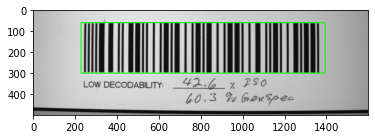

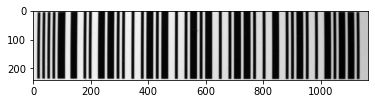

In [26]:
bound_box(f'images/{images_paths[19]}')

[[ 247.  143.]
 [1416.  131.]
 [ 249.  383.]
 [1418.  372.]]


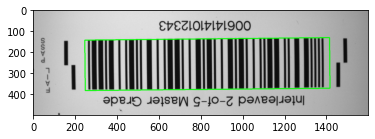

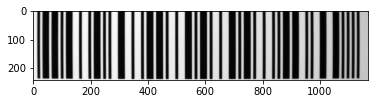

In [27]:
bound_box(f'images/{images_paths[20]}')

In [28]:
print(f'images/{images_paths[21]}')

images/TestChart.xls


In [29]:
#bound_box(f'images/{images_paths[21]}')

[[192. 214.]
 [885. 210.]
 [195. 644.]
 [887. 640.]]


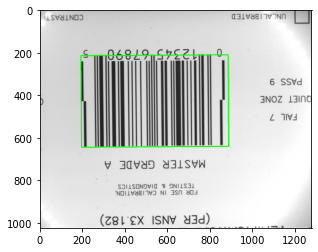

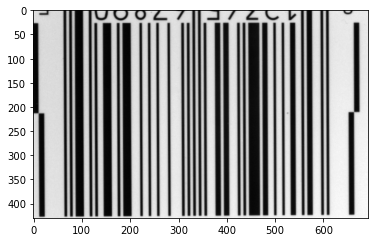

In [30]:
bound_box(f'images/{images_paths[22]}')

[[309. 308.]
 [905. 312.]
 [306. 737.]
 [901. 742.]]


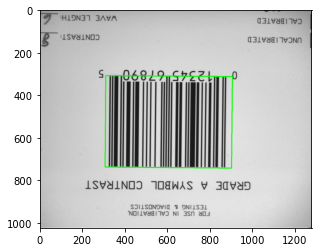

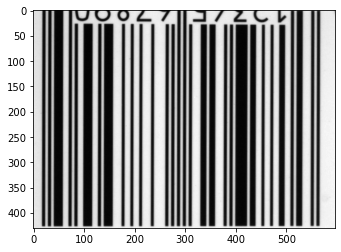

In [31]:
bound_box(f'images/{images_paths[23]}')

[[343. 303.]
 [936. 313.]
 [336. 733.]
 [929. 743.]]


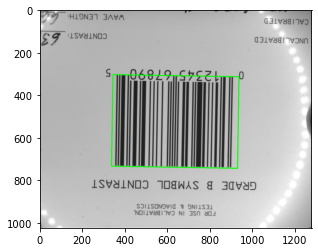

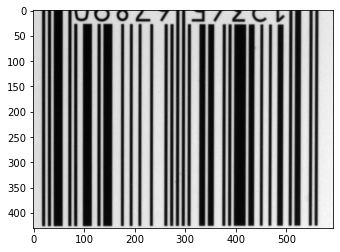

In [32]:
bound_box(f'images/{images_paths[24]}')

[[350. 306.]
 [944. 308.]
 [348. 735.]
 [943. 738.]]


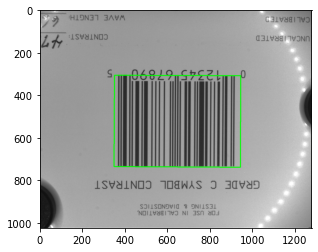

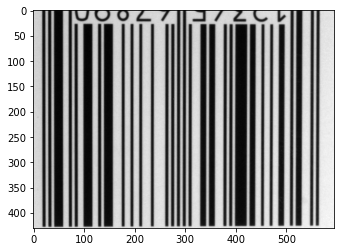

In [33]:
bound_box(f'images/{images_paths[25]}')

[[291. 280.]
 [884. 302.]
 [275. 712.]
 [868. 734.]]


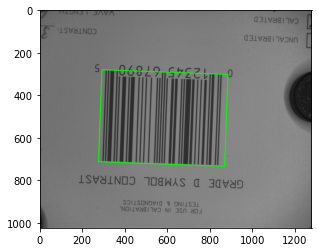

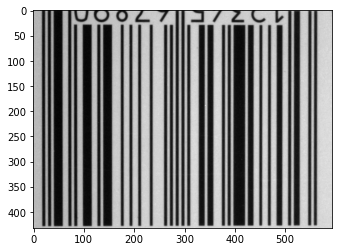

In [34]:
bound_box(f'images/{images_paths[26]}')

[[326. 293.]
 [920. 302.]
 [320. 723.]
 [913. 732.]]


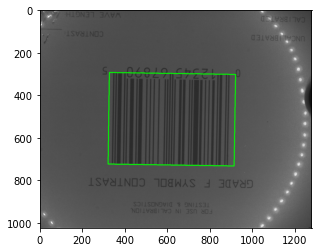

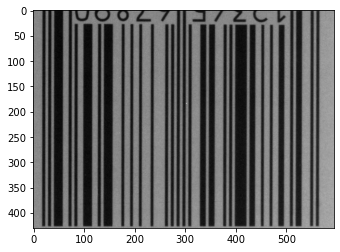

In [35]:
bound_box(f'images/{images_paths[27]}')

[[321. 297.]
 [916. 304.]
 [316. 728.]
 [911. 735.]]


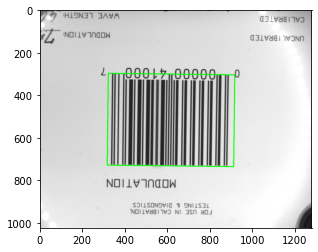

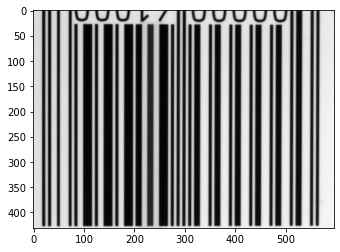

In [36]:
bound_box(f'images/{images_paths[28]}')

[[321. 302.]
 [916. 311.]
 [314. 734.]
 [909. 743.]]


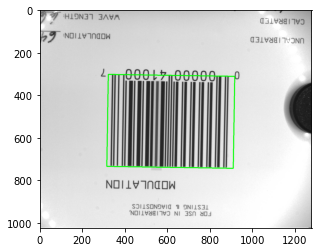

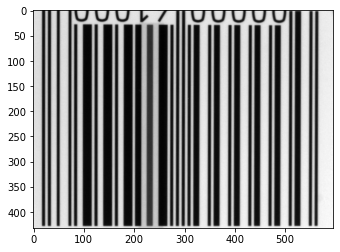

In [37]:
bound_box(f'images/{images_paths[29]}')

[[318. 312.]
 [913. 324.]
 [310. 744.]
 [905. 755.]]


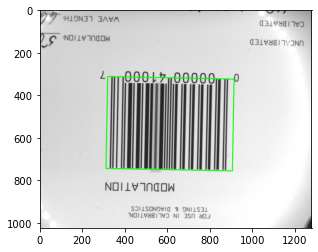

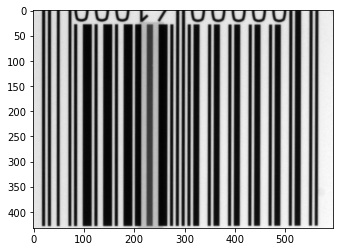

In [38]:
bound_box(f'images/{images_paths[30]}')

[[326. 300.]
 [920. 317.]
 [314. 732.]
 [908. 749.]]


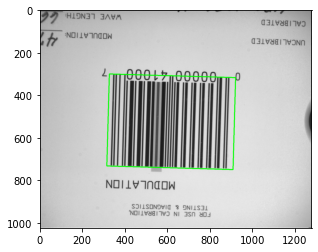

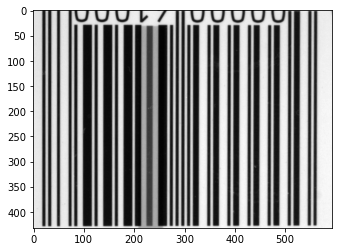

In [39]:
bound_box(f'images/{images_paths[31]}')

[[328. 294.]
 [922. 294.]
 [328. 724.]
 [922. 724.]]


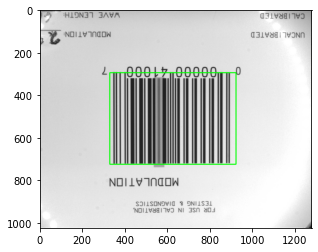

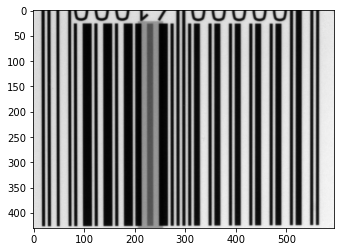

In [40]:
bound_box(f'images/{images_paths[32]}')

[[339. 301.]
 [933. 305.]
 [335. 752.]
 [930. 756.]]


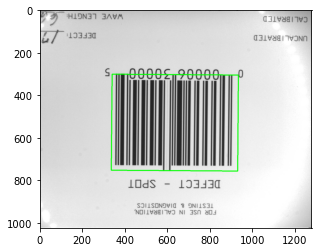

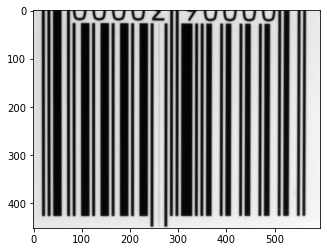

In [41]:
bound_box(f'images/{images_paths[34]}')

[[339. 290.]
 [933. 299.]
 [332. 733.]
 [927. 742.]]


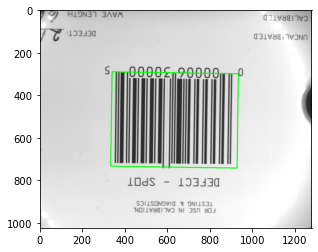

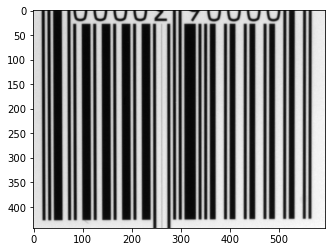

In [42]:
bound_box(f'images/{images_paths[35]}')

[[327. 296.]
 [920. 296.]
 [327. 746.]
 [920. 746.]]


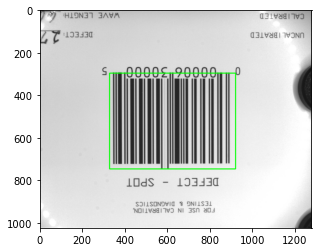

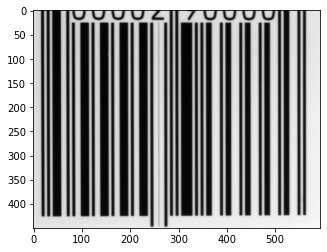

In [43]:
bound_box(f'images/{images_paths[36]}')

[[314. 302.]
 [908. 302.]
 [314. 753.]
 [908. 753.]]


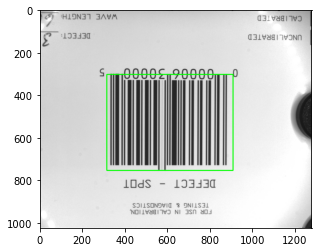

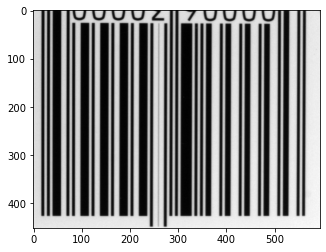

In [44]:
bound_box(f'images/{images_paths[37]}')

[[325. 302.]
 [920. 302.]
 [325. 733.]
 [920. 733.]]


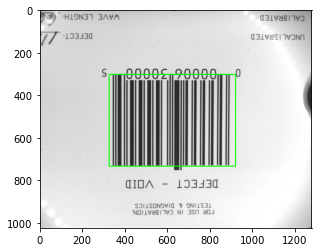

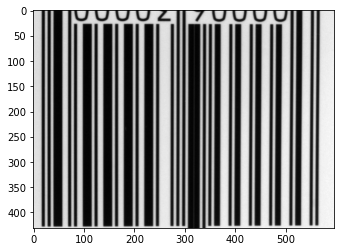

In [45]:
bound_box(f'images/{images_paths[38]}')

[[329. 295.]
 [924. 299.]
 [325. 725.]
 [920. 730.]]


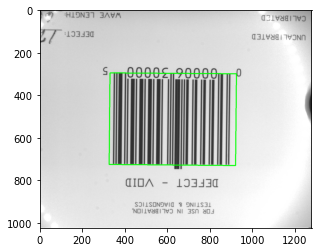

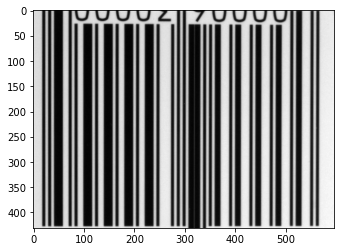

In [46]:
bound_box(f'images/{images_paths[39]}')

[[293. 304.]
 [888. 306.]
 [291. 734.]
 [887. 737.]]


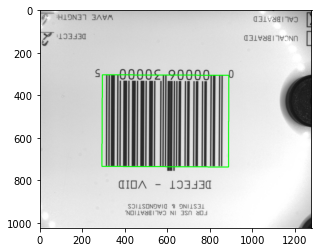

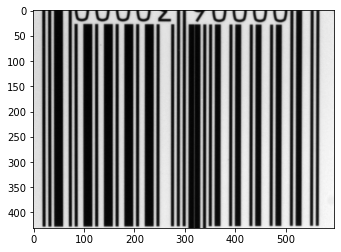

In [47]:
bound_box(f'images/{images_paths[40]}')

[[283. 298.]
 [878. 295.]
 [285. 727.]
 [880. 725.]]


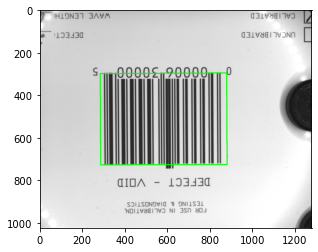

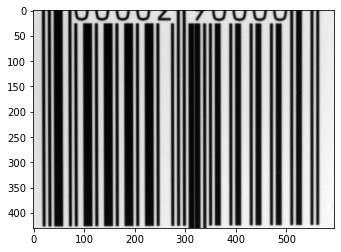

In [48]:
bound_box(f'images/{images_paths[41]}')

[[281. 295.]
 [876. 295.]
 [281. 746.]
 [876. 746.]]


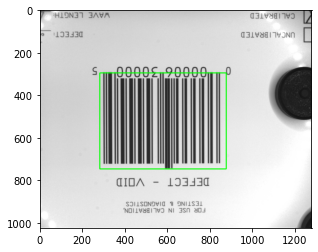

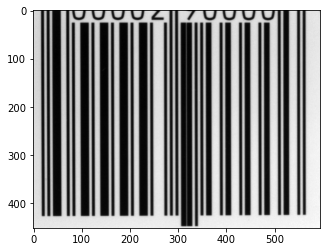

In [49]:
bound_box(f'images/{images_paths[42]}')

[[275. 290.]
 [870. 290.]
 [275. 720.]
 [870. 720.]]


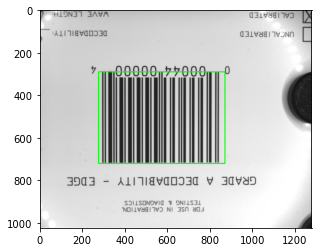

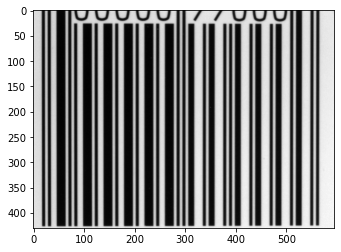

In [50]:
bound_box(f'images/{images_paths[43]}')

[[285. 295.]
 [880. 298.]
 [282. 726.]
 [878. 729.]]


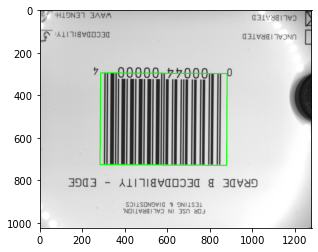

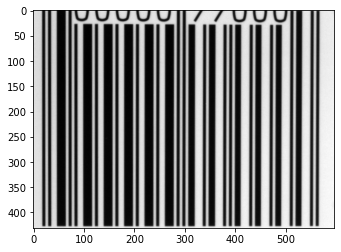

In [51]:
bound_box(f'images/{images_paths[44]}')

[[274. 307.]
 [869. 310.]
 [272. 738.]
 [867. 741.]]


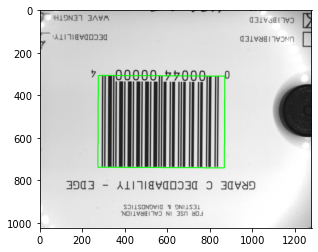

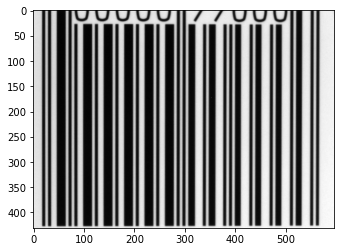

In [52]:
bound_box(f'images/{images_paths[45]}')

[[258. 296.]
 [854. 303.]
 [253. 727.]
 [848. 734.]]


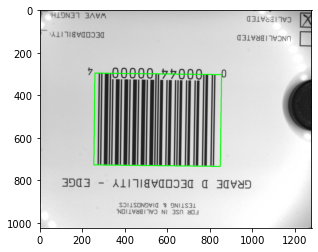

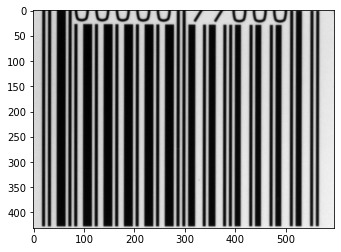

In [53]:
bound_box(f'images/{images_paths[46]}')

[[253. 304.]
 [849. 309.]
 [249. 735.]
 [845. 740.]]


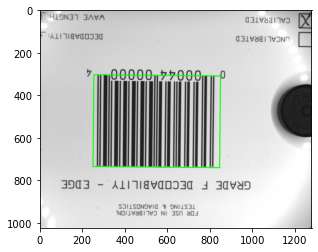

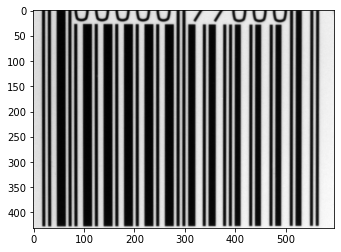

In [54]:
bound_box(f'images/{images_paths[47]}')

[[246. 302.]
 [842. 309.]
 [242. 734.]
 [838. 740.]]


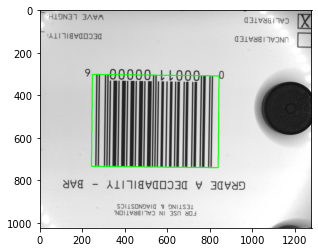

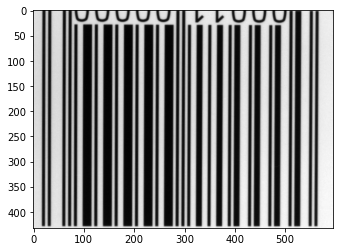

In [55]:
bound_box(f'images/{images_paths[48]}')

[[250. 303.]
 [847. 310.]
 [245. 735.]
 [842. 742.]]


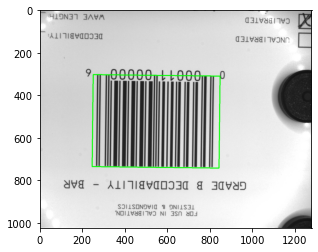

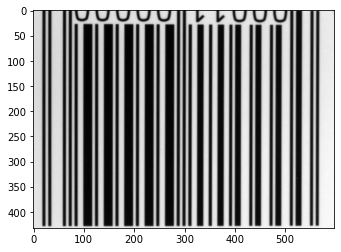

In [56]:
bound_box(f'images/{images_paths[49]}')

[[275. 281.]
 [871. 289.]
 [270. 712.]
 [865. 719.]]


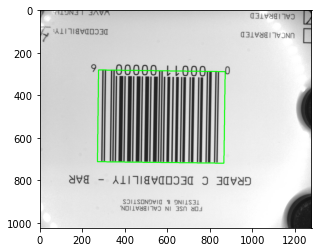

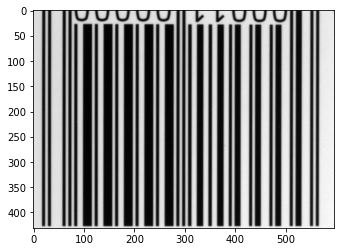

In [57]:
bound_box(f'images/{images_paths[50]}')

[[277. 290.]
 [873. 298.]
 [271. 722.]
 [867. 731.]]


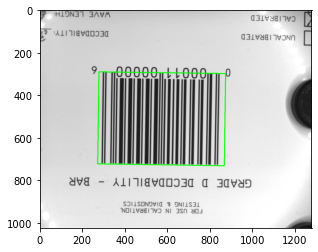

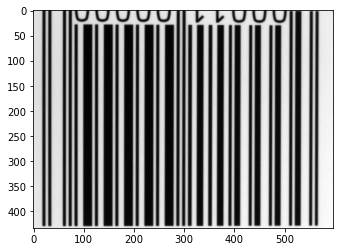

In [58]:
bound_box(f'images/{images_paths[51]}')

[[290. 294.]
 [885. 295.]
 [290. 724.]
 [885. 724.]]


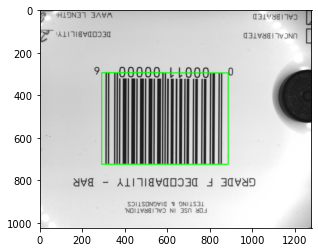

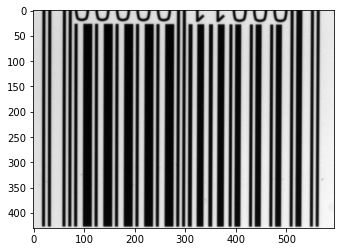

In [59]:
bound_box(f'images/{images_paths[52]}')

In [65]:
%%time
bound_box('other images/1.png')

IndexError: list index out of range